# Initial Data Exploration For Microscopic Image Morphing And Generating Intermediate Images

## Used imports

In [1]:
import openslide # Loading WSI images
import cv2 # Image processing
from scipy.spatial.distance import jensenshannon # Jensen-Shannon Distance
from PIL import Image
from skimage import io, color
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.color import separate_stains, hdx_from_rgb # Ruifrok and Johnston deconvolution


import matplotlib.pyplot as plt
import numpy as np

## Define notebook static variables

In [2]:
data_dir = '../data/'

## Display data
Data for this project consists of histologic WSI images of colon tissue stained with **[haematoxylin](https://en.wikipedia.org/wiki/Haematoxylin)** and **[eosin](https://en.wikipedia.org/wiki/Eosin)**. Each scan contain 3 consecutive tissue`s layers which will be used for morphing the 2 outermost elements to be as simmilar as possible to the middle one  

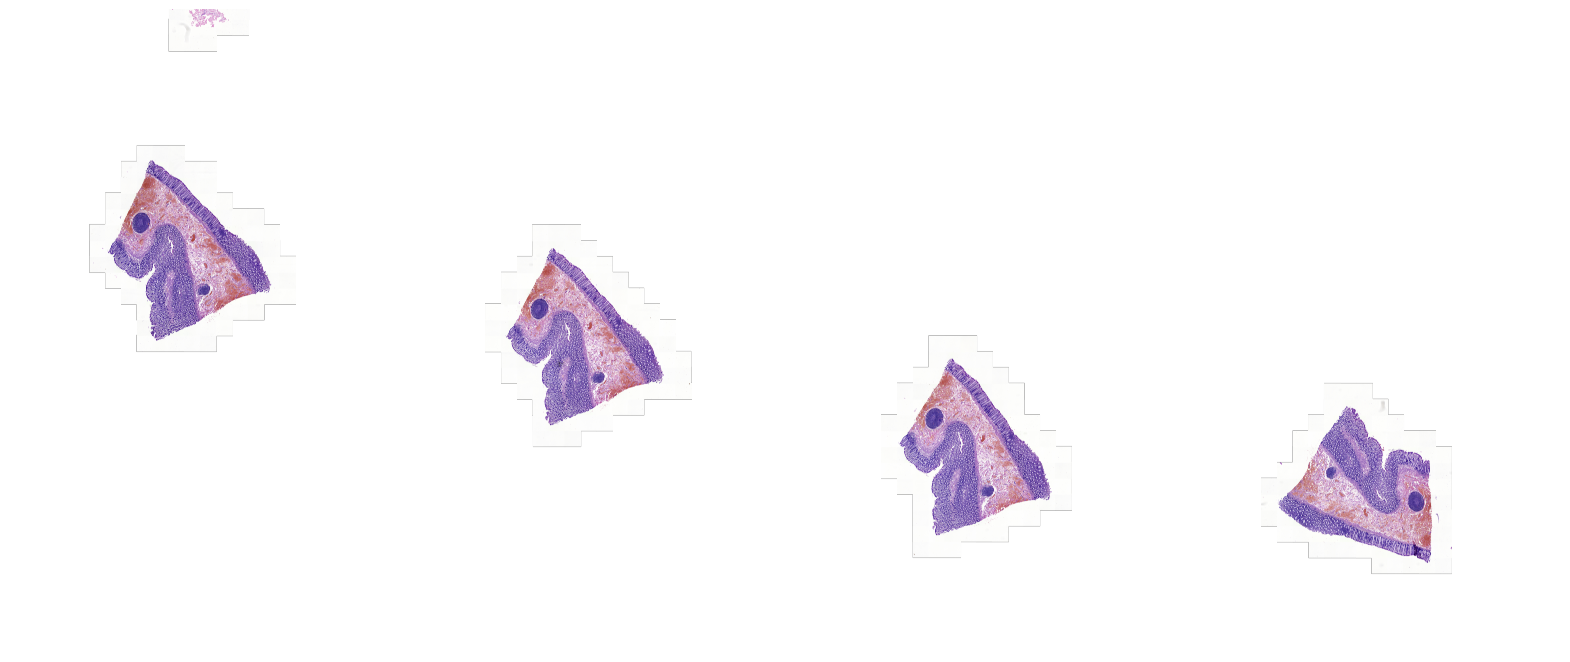

In [3]:
slide = openslide.OpenSlide(data_dir + '1M02.mrxs')

level = 2
image = slide.read_region((0, 0), level, slide.level_dimensions[level])
image = image.transpose(method=Image.Transpose.ROTATE_90)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image)
ax.axis('off')
plt.show()

## Object detection
The first challenge in the process is to extract relevant regions of interest (tissue samples) from the image. To achieve this, I will employ the **[Canny edge detection algorithm](https://en.wikipedia.org/wiki/Canny_edge_detector)** on a downscaled version of the whole slide image. This step enables the identification of approximate contours corresponding to the tissue structures. Subsequently, these contours will be analyzed to determine bounding boxes that encapsulate the detected objects, with an additional offset applied to ensure complete coverage of the tissue region.

The resulting bounding box is defined relative to the image dimensions, allowing for flexible scaling to any resolution level. This transformation is achieved using a coordinate translation function, ensuring consistency across different magnification levels.

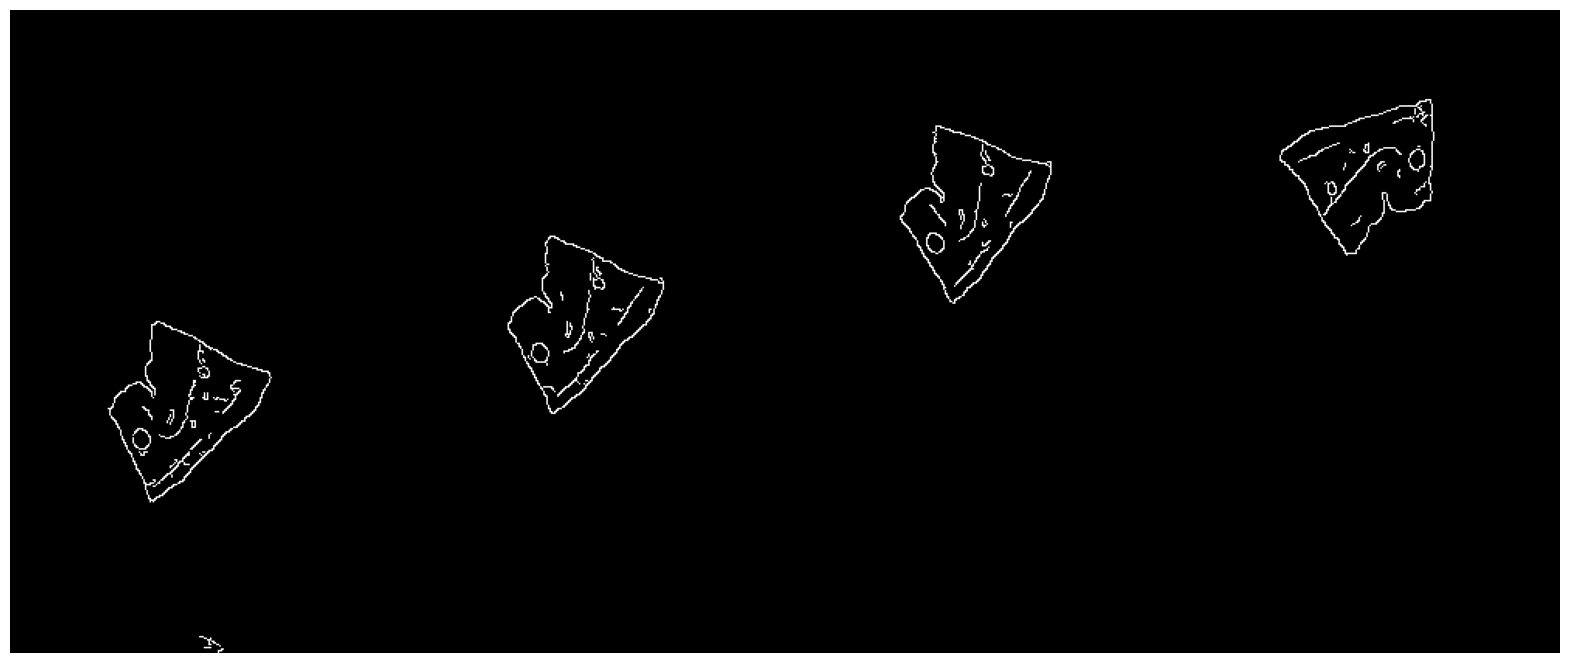

In [4]:
# Get miniature
t_img = slide.get_thumbnail((1000, 1000))
# Convert image to ndarray and gray-scale
t_img = cv2.cvtColor(np.array(t_img), cv2.COLOR_BGR2GRAY)
# Detect edges in image
edges = cv2.Canny(t_img, 150, 250)
# Get contures of our samples
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(edges.T, cmap='gray')
ax.axis('off')
plt.show()

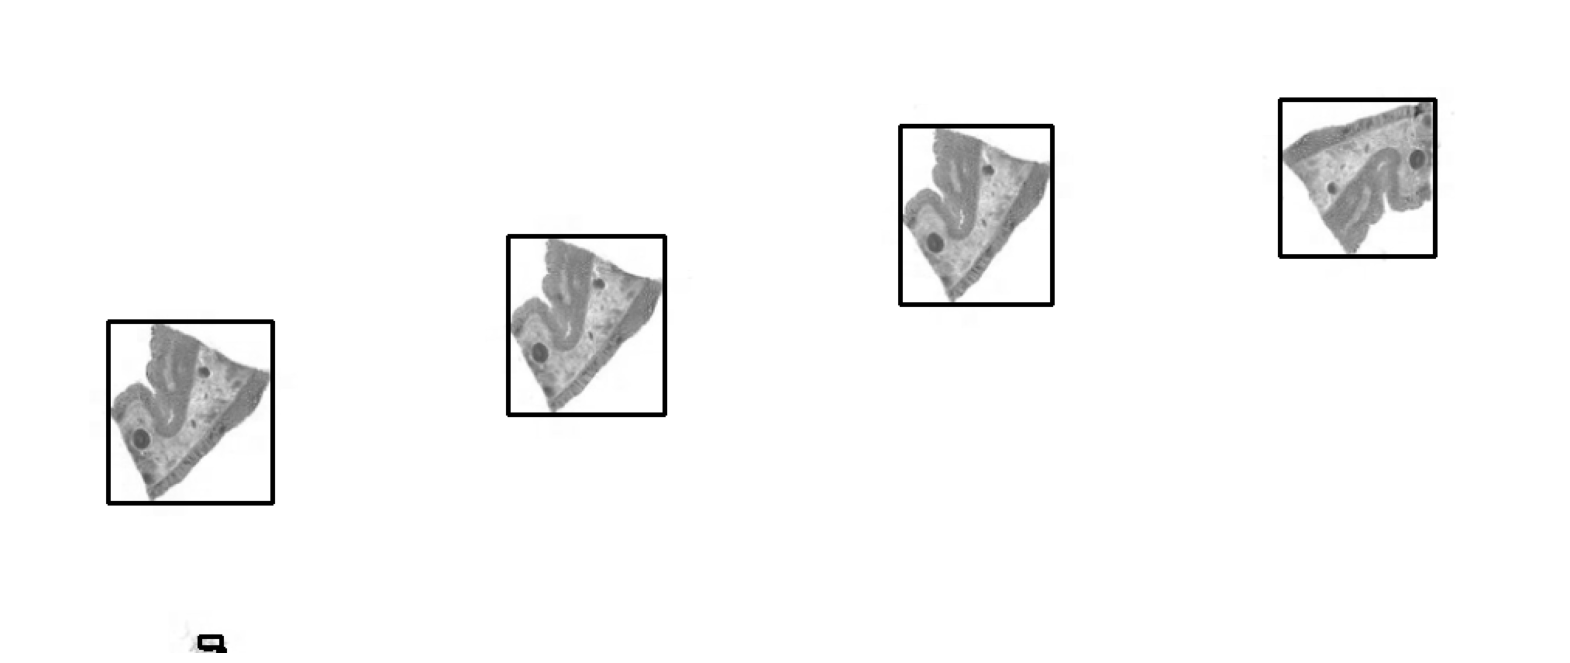

In [5]:
# Get bounding rectangles for detected contours
rects = []
for contour in contours:
    rect = cv2.boundingRect(contour)
    rects.append(rect)

# Check if contures are external
rects.sort(key=lambda x: x[2]*x[3], reverse=True)

def contains(rect_a, rect_b):
    x1, y1, w1, h1 = rect_a
    x2, y2, w2, h2 = rect_b
    return x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2

valid_bounds = []

for rect_a in rects:
    is_valid = True
    for rect_b in valid_bounds:
        if contains(rect_b, rect_a):
            is_valid = False
            break
    
    if is_valid:
        # Plot valid external rectangles on the miniature
        valid_bounds.append(rect_a)
        x, y, w, h = rect_a
        cv2.rectangle(t_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(t_img.T, cmap='gray')
ax.axis('off')
plt.show()

### Function definition to get rectangles of tissue regions

In [6]:
def get_tissue_regions(slide: openslide.OpenSlide, box_offset: tuple = (20, 20)):
    img_t = slide.get_thumbnail((1000, 1000))

    # Image pre-processing
    t_img = slide.get_thumbnail((1000, 1000))
    t_img = cv2.cvtColor(np.array(t_img), cv2.COLOR_BGR2GRAY)

    # Contour detection
    edges = cv2.Canny(t_img, 150, 250)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get rectangles
    rects = []
    for contour in contours:
        rect = cv2.boundingRect(contour)
        rects.append(rect)

    # Validate if bound is external
    rects.sort(key=lambda x: x[2]*x[3], reverse=True)
    def contains(rect_a, rect_b):
        x1, y1, w1, h1 = rect_a
        x2, y2, w2, h2 = rect_b
        return x1 <= x2 and y1 <= y2 and x1 + w1 >= x2 + w2 and y1 + h1 >= y2 + h2
    
    valid_bounds = []

    for rect_a in rects:
        is_valid = True
        for rect_b in valid_bounds:
            if contains(rect_b, rect_a):
                is_valid = False
                break
        
        if is_valid:
           valid_bounds.append(rect_a)

    # Offset bounding rectangle 
    result = []
    for bound in valid_bounds:
        x, y, w, h = bound
        result.append((
            (x - box_offset[0]) / t_img.shape[1],
            (y - box_offset[1]) / t_img.shape[0],
            (w + 2*box_offset[0]) / t_img.shape[1],
            (h + 2*box_offset[1]) / t_img.shape[0]
        ))
        
    return result

# Helper function to translate relative rectangle to specific LoD rectangle
def translate_rect(slide: openslide.OpenSlide, level: int, rect: tuple):
    assert level >= 0 and level < slide.level_count
    x, y, w, h = rect
    dim_size = slide.level_dimensions[level]
    dim_pos = slide.level_dimensions[0]

    return int(x * dim_pos[0]), int(y * dim_pos[1]), int(w * dim_size[0]), int(h * dim_size[1])

objs_pos = get_tissue_regions(slide)

### Example use of 'get_tissue_region' and 'translate_rect' functions

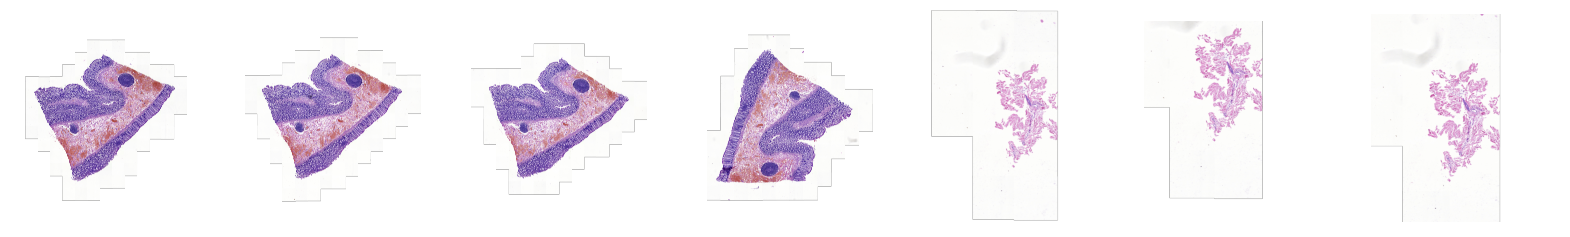

In [7]:
fig, axes = plt.subplots(1, len(objs_pos), figsize=(20, 20))

obj_images = []

for i, pos in enumerate(objs_pos):
    level = 2
    x, y, w, h = translate_rect(slide, level, pos)
    
    image = slide.read_region((x, y), level, (w, h))
    obj_images.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

### Tissue object size treshold
The size threshold for filtering tissue objects is dynamically determined by identifying the largest drop in area between two consecutive elements in a list of tissue regions sorted by area. This method assumes that a significant decrease in size indicates a transition from relevant tissue to small fragments or noise. The threshold is then set to exclude all objects smaller than this point.

Calculated threshold: 0.00611566265060241


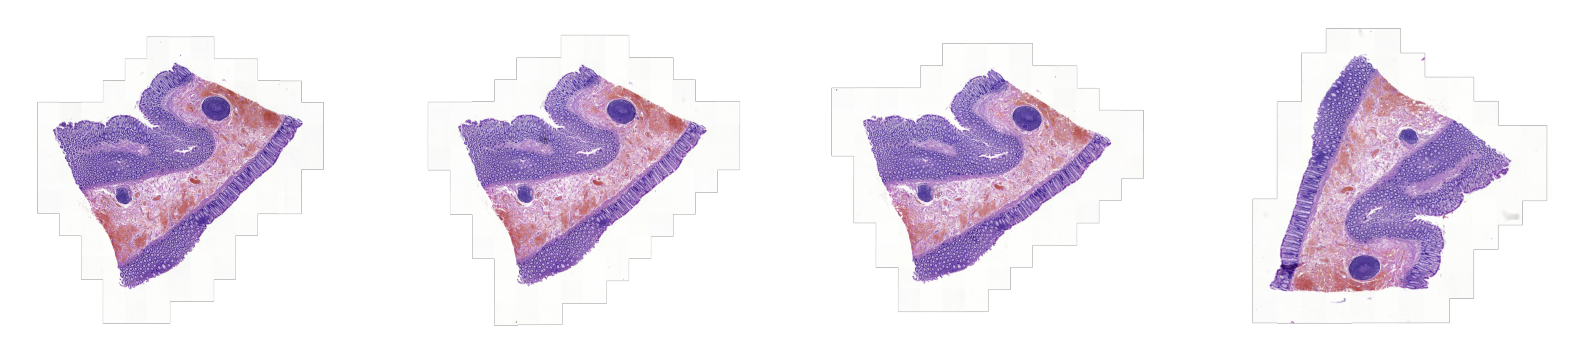

In [8]:
threshold = None
max_prc = 0.2
# Sort tissue rectangles by area
sort_size = sorted(objs_pos, key=lambda x: x[2] * x[3], reverse=True)

# Calculate smallest fraction of size
index = 0
smallest_prc = np.inf
for i in range(1, len(sort_size)):
    a1 = objs_pos[i-1][2] * objs_pos[i-1][3]
    a2 = objs_pos[i][2] * objs_pos[i][3]
    prc = a2/a1

    if prc < smallest_prc:
        smallest_prc = prc
        index = i
        
cleaned_objs_pos = objs_pos
if smallest_prc < max_prc:
    area = objs_pos[index][2] * objs_pos[index][3]
    threshold = area
    cleaned_objs_pos = [rect for rect in objs_pos if rect[2] * rect[3] > threshold]

print(f'Calculated threshold: {threshold}')

obj_images = []
fig, axes = plt.subplots(1, len(cleaned_objs_pos), figsize=(20, 20))
for i, pos in enumerate(cleaned_objs_pos):
    level = 2
    x, y, w, h = translate_rect(slide, level, pos)
    
    image = slide.read_region((x, y), level, (w, h))
    obj_images.append(image)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

## Mask tissue sample from background

### Ruifrok and Johnston deconvolution for background removal

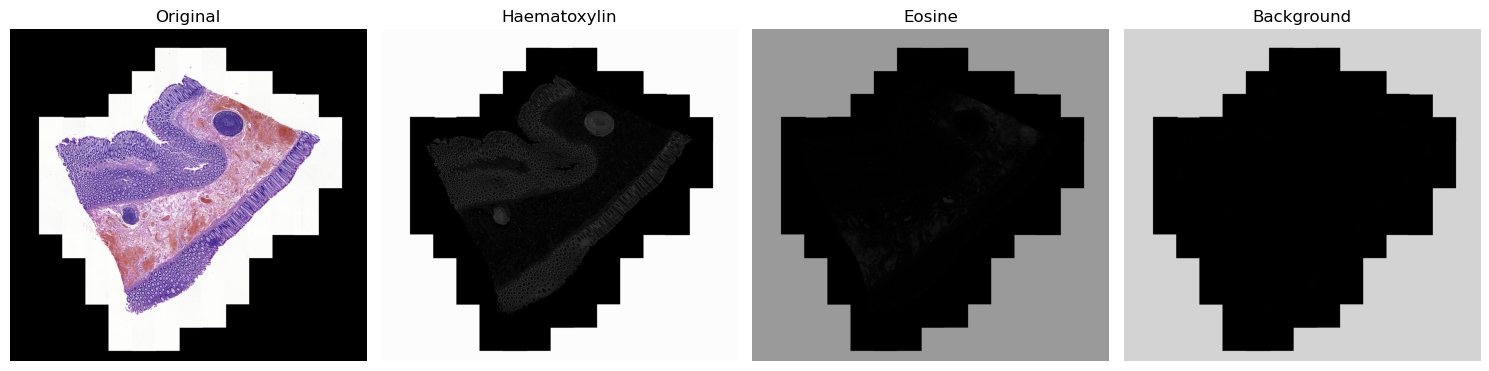

In [9]:
# Example image of one sample
image = np.array(obj_images[0])[:,:,:-1]

# Stain matrix for haematoxylin and eosin
stain_matrix = hdx_from_rgb
deconvoluted = separate_stains(image, stain_matrix)
# Scale intensity to equalize histograms

hematoxylin = deconvoluted[:, :, 0]
eosin = deconvoluted[:, :, 1]
background = deconvoluted[:, :, 2]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(hematoxylin, cmap='gray')
axes[1].set_title("Haematoxylin")
axes[2].imshow(eosin, cmap='gray')
axes[2].set_title("Eosine")
axes[3].imshow(background, cmap='gray')
axes[3].set_title("Background")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Create mask from background channel

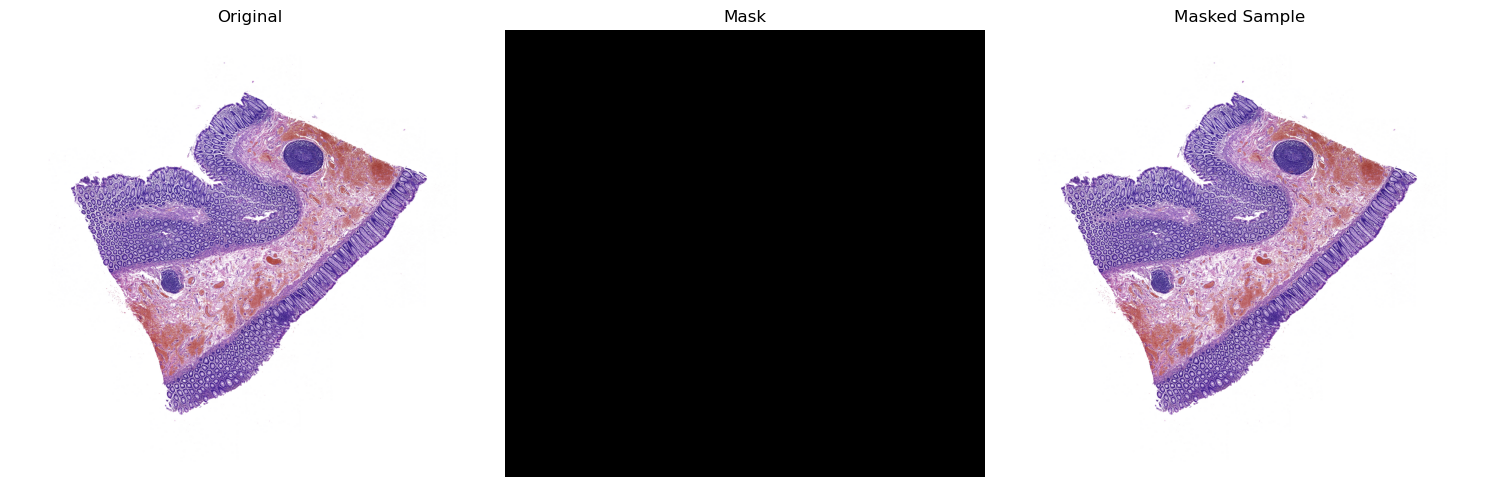

In [28]:
mask = background == 0

# Create image of the mask and apply it
mask_view = (mask * 255).astype(np.uint8)
masked_image = image.copy()
masked_image[~mask] = 255

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(mask_view, cmap='gray')
axes[1].set_title("Mask")
axes[2].imshow(masked_image)
axes[2].set_title("Masked Sample")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Function definition to get mask of tissue sample

In [29]:
def get_sample_mask(sample: np.ndarray):
    assert(sample.shape[-1] == 3)
    
    # Get background in hdx of sample
    stain_matrix = hdx_from_rgb
    background = separate_stains(sample, stain_matrix)[...,-1]
    
    return background == 0

### Masking background from all samples

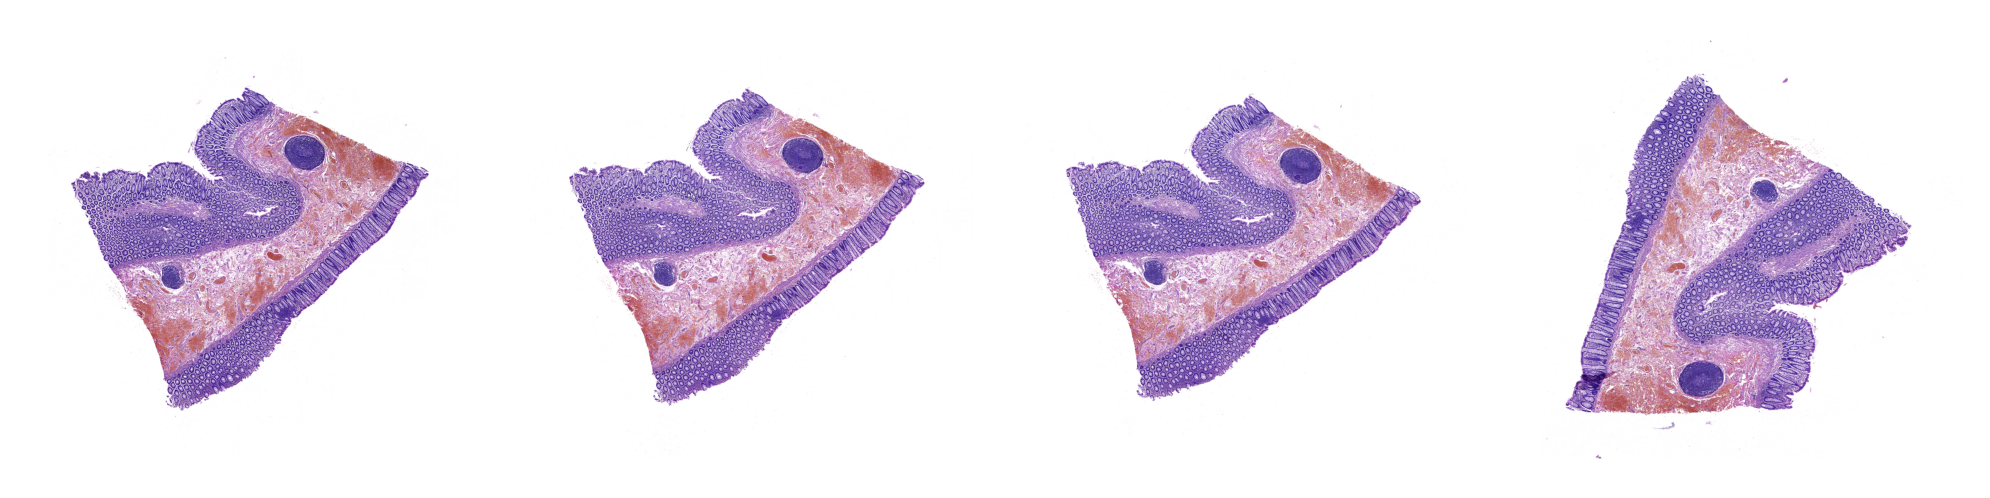

In [30]:
fig, axes = plt.subplots(1, len(obj_images), figsize=(20, 20))

for i in range(len(obj_images)):
    obj_images[i] = np.array(obj_images[i])[:, :, :3]
    obj_images[i][~get_sample_mask(obj_images[i])] = 255

    axes[i].imshow(obj_images[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Sample similarity measure

The next thing to consider during preparation for Image Morphing is the 'simmilarity' score that will measure the performance of our algorithm. The overall score will be comprised of diffrent indicators: MSE (Mean-Square-Error), Histogram Entropy (Jensen-Shannon Distance), Histogram Correlation (Pearson Correlation Coefficient) ...

### Histogram analisys

### RGB Channel split

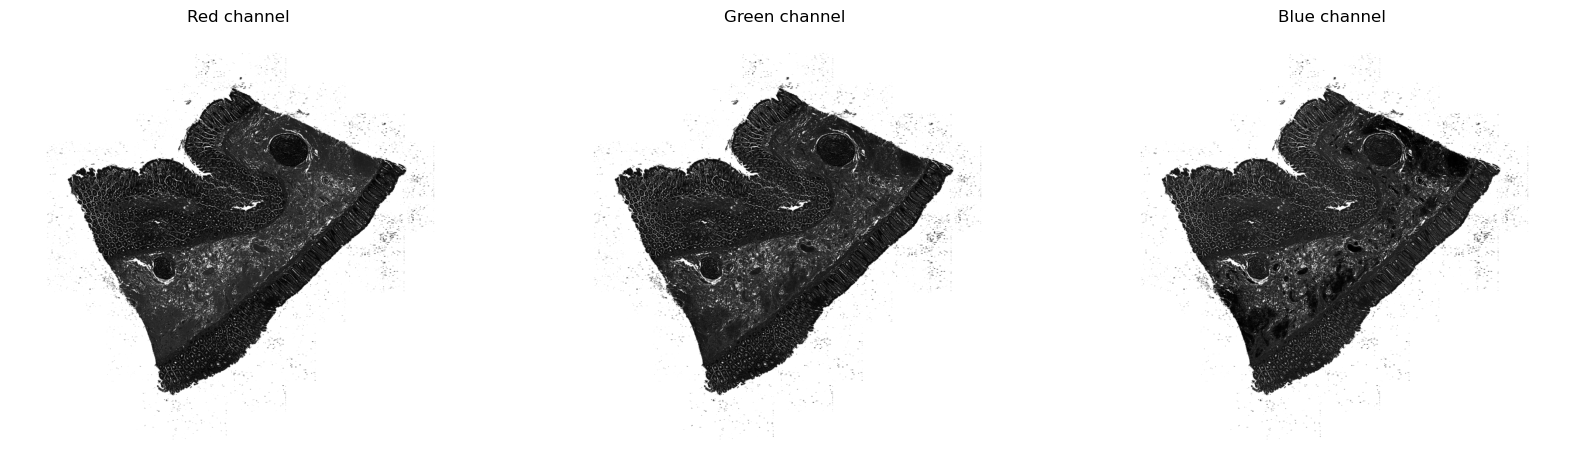

In [13]:
# Example image of one sample
image = np.array(obj_images[0])
# Split BGR channels
planes = cv2.split(image)

# Scale intensity to equalize histograms
temp = []
for i in range(len(planes)):
    temp.append(equalize_hist(planes[i][:, :]))
planes = tuple(temp)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(planes[0], cmap='gray')
axes[0].set_title('Red channel')
axes[1].imshow(planes[1], cmap='gray')
axes[1].set_title('Green channel')
axes[2].imshow(planes[2], cmap='gray')
axes[2].set_title('Blue channel')

for ax in axes:
    ax.axis('off')

plt.show()

### Ruifrok and Johnston deconvolution

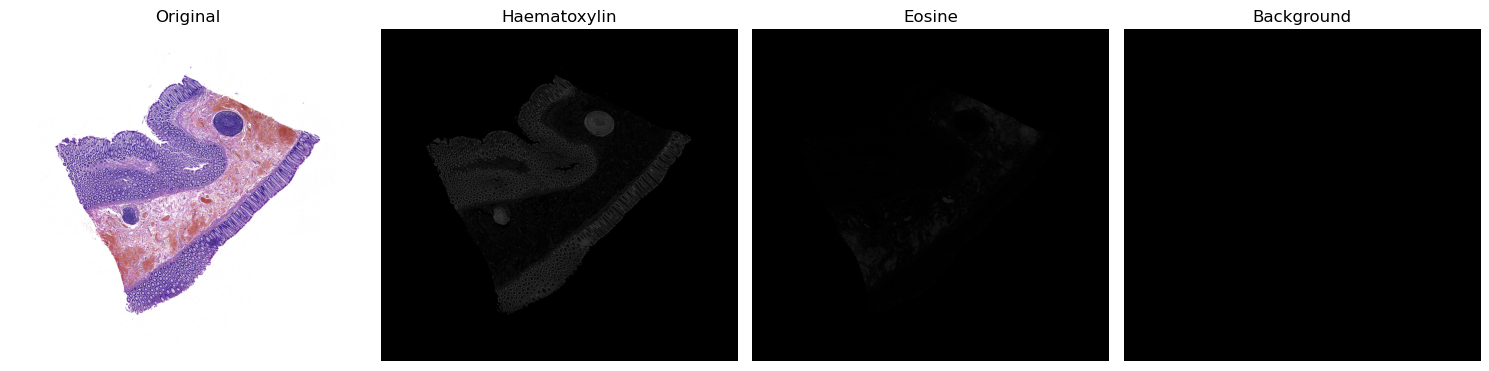

In [15]:
# Example image of one sample 
image = obj_images[0]

# Stain matrix for haematoxylin and eosin
stain_matrix = hdx_from_rgb
deconvoluted = separate_stains(image, stain_matrix)
# Scale intensity to equalize histograms

hematoxylin = deconvoluted[:, :, 0]
eosin = deconvoluted[:, :, 1]
background = deconvoluted[:, :, 2]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[1].imshow(hematoxylin, cmap='gray')
axes[1].set_title("Haematoxylin")
axes[2].imshow(eosin, cmap='gray')
axes[2].set_title("Eosine")
axes[3].imshow(background, cmap='gray')
axes[3].set_title("Background")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

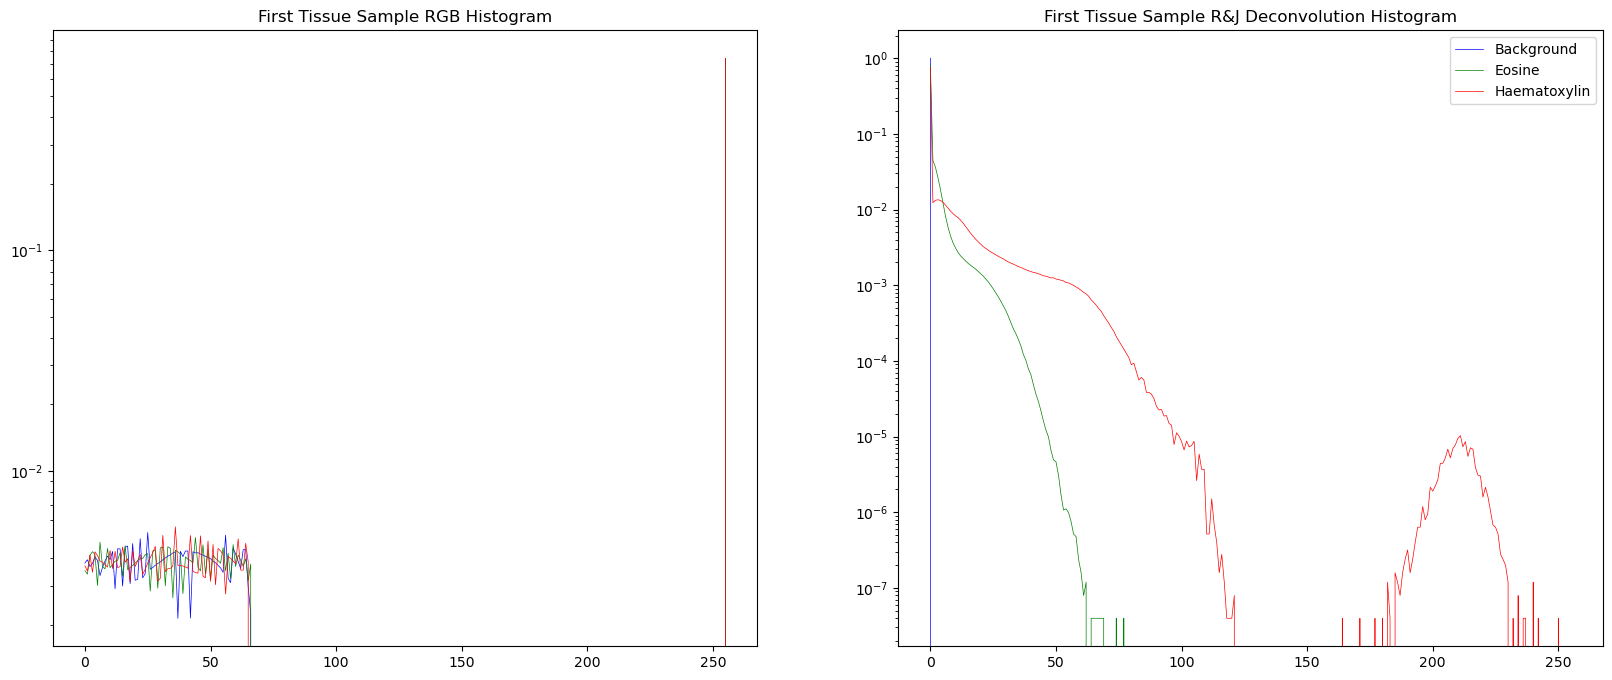

In [16]:
# Histogram parameters
histSize = 256

# Create histogram for each rgb channel
r_hist, _ = np.histogram(planes[0], bins=histSize, range=(0,1))
g_hist, _ = np.histogram(planes[1], bins=histSize, range=(0,1))
b_hist, _ = np.histogram(planes[2], bins=histSize, range=(0,1))

rgb_hists = [r_hist, g_hist, b_hist]

# Create histogram for each deconvoluted channel
h_hist, _ = np.histogram(hematoxylin, bins=histSize, range=(0,1))
e_hist, _ = np.histogram(eosin, bins=histSize, range=(0,1))
bg_hist, _ = np.histogram(background, bins=histSize, range=(0,1))

hebg_hists = [h_hist, e_hist, bg_hist]

# Normalize each histogram
def normalize_hist(hists: list):
    for i in range(len(hists)):
        hists[i] = hists[i] / np.sum(hists[i])

    return hists

rgb_hists = normalize_hist(rgb_hists)
hebg_hists = normalize_hist(hebg_hists)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
axes[0].set_title('First Tissue Sample RGB Histogram')
axes[0].plot(rgb_hists[2], color='blue', linewidth=0.5)
axes[0].plot(rgb_hists[1], color='green', linewidth=0.5)
axes[0].plot(rgb_hists[0], color='red', linewidth=0.5)
axes[0].set_yscale('log')

axes[1].set_title('First Tissue Sample R&J Deconvolution Histogram')
axes[1].plot(hebg_hists[2], color='blue', linewidth=0.5, label='Background')
axes[1].plot(hebg_hists[1], color='green', linewidth=0.5, label = 'Eosine')
axes[1].plot(hebg_hists[0], color='red', linewidth=0.5, label = 'Haematoxylin')
axes[1].set_yscale('log')
axes[1].legend()

plt.show()

### Histogram extraction function 

In [17]:
# Function returns histogram values for channels in order: R, G, B
def extract_rgb_histogram(image: Image.Image, normalize: bool = False):
    # Split image channels
    image = np.array(image)
    planes = cv2.split(image)

    # Histogram parameters
    accumulate = False
    histSize = 256
    histRange = (0, 256)
    hist_w = 512
    hist_h = 400
    bin_w = int(round(hist_w / histSize))
    
    # Create histogram for each channel
    r_hist = cv2.calcHist(planes, [0], None, [histSize], histRange, accumulate=accumulate)
    g_hist = cv2.calcHist(planes, [1], None, [histSize], histRange, accumulate=accumulate)
    b_hist = cv2.calcHist(planes, [2], None, [histSize], histRange, accumulate=accumulate)

    # Normalization
    if normalize:
        b_hist = b_hist / np.sum(b_hist)
        g_hist = g_hist / np.sum(g_hist)
        r_hist = r_hist / np.sum(r_hist)

    return r_hist, g_hist, b_hist

### Histogram entropy indicator (Jensen-Shannon Distance)

In [18]:
# Examples for 
histograms_1 = extract_rgb_histogram(obj_images[0], normalize=True)
histograms_2 = extract_rgb_histogram(obj_images[1], normalize=True)

channels = ['blue', 'green', 'red']

for i in range(3):
    js_distance = jensenshannon(histograms_1[i], histograms_2[i])
    print(f'Jensen-Shannon Distance for channel {channels[i]}: {js_distance}')

Jensen-Shannon Distance for channel blue: [0.03050935]
Jensen-Shannon Distance for channel green: [0.0280896]
Jensen-Shannon Distance for channel red: [0.03163067]


### Histogram pearson correlation coefficient

In [19]:
for i in range(3):
    corr = np.corrcoef(histograms_1[i].flatten(), histograms_2[i].flatten())[0,1]
    print(f'Pearson correlation coefficient for channel {channels[i]}: {corr}')

Pearson correlation coefficient for channel blue: 0.999992965154191
Pearson correlation coefficient for channel green: 0.9999955107899595
Pearson correlation coefficient for channel red: 0.9999927015204262


## Image Mapping

### Scale-invariant feature transform (Sift)

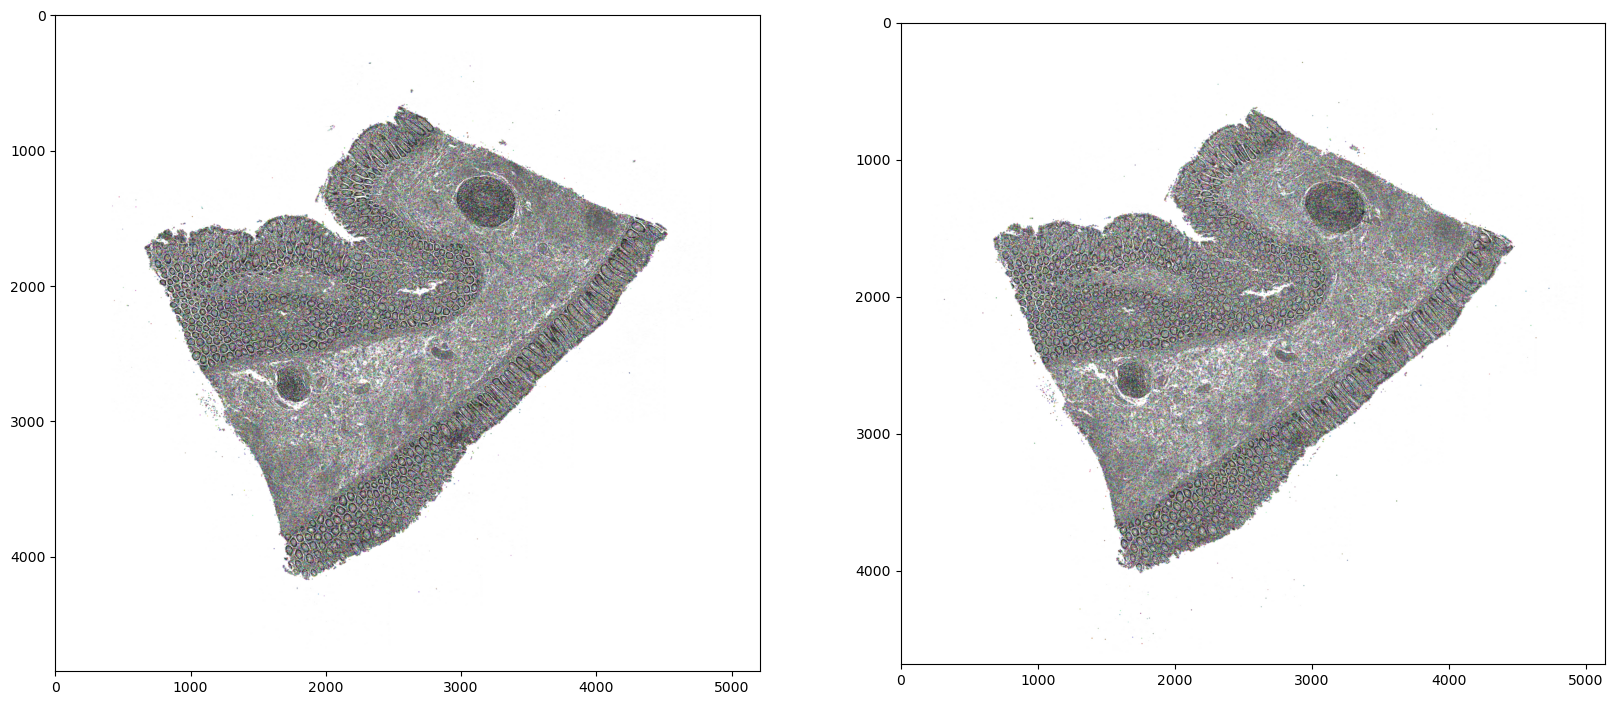

In [20]:
img1 = np.array(obj_images[0])
img2 = np.array(obj_images[1])

gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

kp_img1=cv2.drawKeypoints(gray1,kp1,img1)
kp_img2=cv2.drawKeypoints(gray2,kp2,img2)

fig, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(kp_img1)
axes[1].imshow(kp_img2)
plt.show()

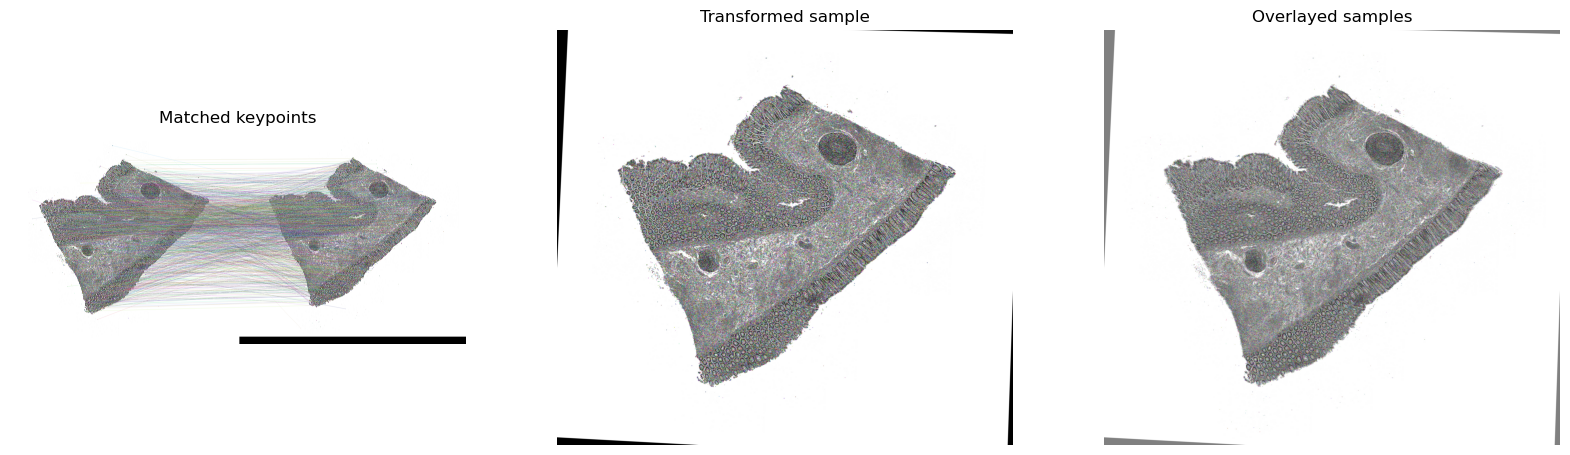

In [21]:
flann = cv2.FlannBasedMatcher()
matches = flann.knnMatch(des1, des2, k=2)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
transformed = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))
overlay = cv2.addWeighted(img2, 0.5, transformed, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(20, 20))
axes[0].imshow(matched_image)
axes[0].set_title('Matched keypoints')
axes[1].imshow(transformed)
axes[1].set_title('Transformed sample')
axes[2].imshow(overlay)
axes[2].set_title('Overlayed samples')

for ax in axes:
    ax.axis('off')

plt.show()